In [1]:
pip -q install numpy seaborn pandas keras nltk tensorflow tf-models-official torch matplotlib transformers Iprogress sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

2022-12-07 22:35:11.762501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 22:35:12.450248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-12-07 22:35:12.450324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-12-07 22:35:12.450330: W tensorflow/compiler/tf2tensorrt/ut

## BBC News Summary EDA
TODO: add general description here

### Data preperation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [3]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

Total Items loaded: 2224
Total Items loaded: 2224


,label,text
0,tech,British Library gets wireless net\n\nVisitors ...
1,tech,Solutions to net security fears\n\nFake bank e...
2,tech,Camera phones are 'must-haves'\n\nFour times m...
3,tech,Progress on new internet domains\n\nBy early 2...
4,tech,Supercomputer breaks speed record\n\nThe US is...


### Lets see an example from the dataset

In [4]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in politics:
Councils prepare to set tax rises

Council tax in Scotland is set to rise by an average of about 4% in the coming year, BBC Scotland has learned.

Authorities will decide final figures on Thursday when projected increases will be more than twice the rate of inflation, which is currently 1.6%. The finance minister has urged councils to limit increases but they have warned that they will struggle to maintain services unless funding is increased. They say much additional government money is for new initiatives. Scottish Finance Minister, Tom McCabe MSP, said: "Last week in parliament I announced an additional £419m for core expenditure to local government in Scotland. "That's a 5.5% increase and sits against an inflation rate of 1.6%, so I think we have quite rightly said to councils this year that we would at the very least ask them to exercise restraint." Mr McCabe is also looking for local autho

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [5]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

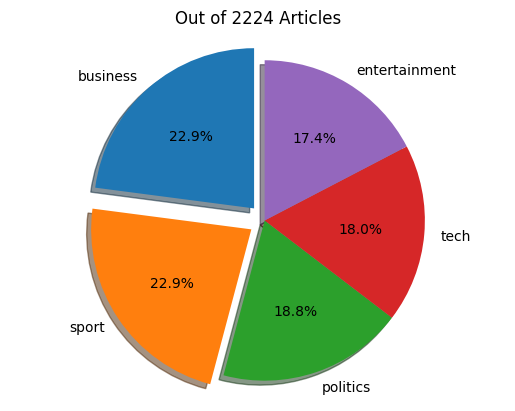

In [6]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


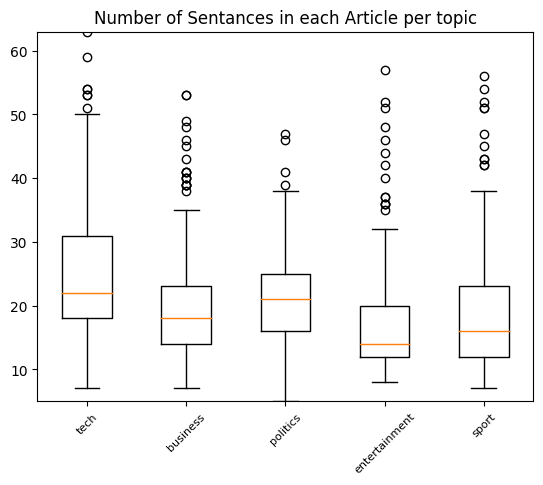

,tech,business,politics,entertainment,sport
count,401.000000,510.000000,417.000000,386.000000,510.000000
mean,25.842893,19.680392,22.227818,17.945596,18.280392
std,12.904370,7.409560,15.467658,14.270836,9.876736
min,7.000000,7.000000,5.000000,8.000000,7.000000
25%,18.000000,14.000000,16.000000,12.000000,12.000000
50%,22.000000,18.000000,21.000000,14.000000,16.000000
75%,31.000000,23.000000,25.000000,20.000000,23.000000
max,161.000000,53.000000,246.000000,205.000000,82.000000


In [7]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


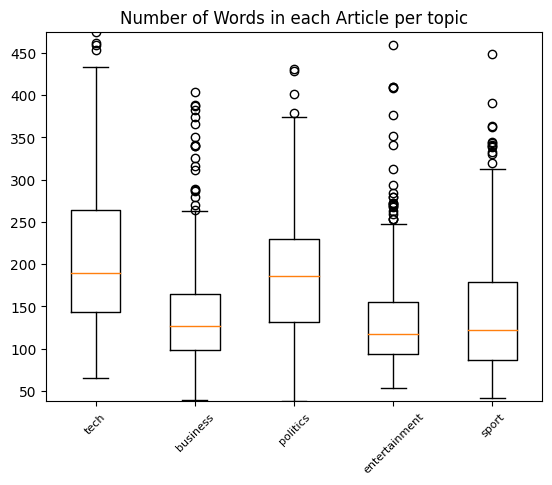

,tech,business,politics,entertainment,sport
count,401.000000,510.00000,417.000000,386.00000,510.000000
mean,213.880299,139.94902,195.738609,144.07772,143.194118
std,111.675336,59.48480,139.855957,124.31821,80.966871
min,65.000000,40.00000,38.000000,54.00000,42.000000
25%,144.000000,99.00000,132.000000,93.25000,87.000000
50%,189.000000,127.00000,186.000000,117.00000,122.000000
75%,264.000000,164.75000,230.000000,154.75000,178.500000
max,1433.000000,403.00000,2074.000000,1708.00000,659.000000


In [8]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [9]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
tech summaries: 57.2868%
business summaries: 56.8027%
politics summaries: 56.5632%
entertainment summaries: 56.0781%
sport summaries: 55.5133%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [10]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentances(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentances(articles_df["text"])
summary_sentances = get_sentances(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /home/nelly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

In [11]:
# Rarity of words used

In [12]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Most common words after stop words

[nltk_data] Downloading package stopwords to /home/nelly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Additional NLP statistics

## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [14]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentances(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['Visitors to the British Library will be able to get wireless internet access alongside the extensive information available in its famous reading rooms.', 'Broadband wireless connectivity will be made available in the eleven reading rooms, the auditorium, caf&#233;, restaurant, and outdoor Piazza area.']

Example summary: ['"At the British Library we are continually exploring ways in which technology can help us to improve services to our users," said Lynne Brindley, chief executive of the British Library.', 'The majority of visitors wanted to be able to access their e-mail as well as the British Library catalogue.', 'Visitors to the British Library will be able to get wireless internet access alongside the extensive information available in its famous reading rooms.', "The technology has been on trial since May and usage levels make the Library London's most active public hotspot.", 'The British Library receives around 3,000 visitors each day and serves around 500,0

## Preprocessing For Extractive Text Summarization

In [15]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary and len(sentance_a)>3:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        labels.append(sentance_inclusion)
        
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

#y_labels = generate_labels(articles_df, summaries_df) 

# Expand contractions
# lowercase
# Remove digits and words containing digits
# Remove punctuations
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

## Naive extractive model based on single sentance analysis

In [16]:
article_sentances = get_sentances(articles_df["text"])
y_labels = generate_labels(articles_df, summaries_df) 

Percent Complete: 100.00%
Matching  labels  1867
Total  2224
Total Sentances processed 46905


In [17]:
import tensorflow as tf
from tensorflow_models import nlp
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.utils import pad_sequences
import string 

def ex_standarize(input_txt):
  lowercase_txt = tf.strings.lower(input_txt)
  return tf.strings.regex_replace(lowercase_txt,'[%s]' % re.escape(string.punctuation),'')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=ex_standarize,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(articles_df["text"])

all_sentances = []
all_labels = []

for i in range(len(article_sentances)):
    for j in range(len(article_sentances[i])):
        all_sentances.append(article_sentances[i][j])
        all_labels.append(y_labels[i][j])

x_train = vectorize_layer(all_sentances)
y_train = np.asarray(all_labels)
print(f"There are {len(x_train)} sentances in total")
print(f"Vecorized sentance sample: {x_train[1][:10]}")
print(f"Corresponding label: {y_train[1]}")

/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from

There are 46905 sentances in total
Vecorized sentance sample: [1447    3    2  157 3925   23   15  297    3   89]
Corresponding label: 1


In [18]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [19]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [20]:

epochs = 10
history = model.fit(
    x=x_train, y=y_train,
    epochs=epochs)

Epoch 1/10


2022-12-07 22:36:55.660167: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5629cd2574e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-07 22:36:55.660187: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2022-12-07 22:36:55.665365: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-07 22:36:55.681133: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  Fo

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_1' defined at (most recent call last):
    File "/home/nelly/.pyenv/versions/3.8.13/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/nelly/.pyenv/versions/3.8.13/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/nelly/.pyenv/versions/3.8.13/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/nelly/.pyenv/versions/3.8.13/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/nelly/.pyenv/versions/3.8.13/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3055/2508610431.py", line 2, in <module>
      history = model.fit(
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_1'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_1}}]] [Op:__inference_train_function_1253]

## Preprocessing For Abstractive Text Summarization

In [ ]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small" # you can specify the model size here
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 30

def preprocess_function(article, summary):
    model_inputs = tokenizer(
        article,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )
    labels = tokenizer(
        summary, max_length=MAX_TARGET_LENGTH, truncation=True
    )
    #model_inputs["labels"] = articles["labels"]
    return model_inputs

for i in range(articles_df.shape[0]):
    result = preprocess_function(articles_df["text"][0], summaries_df["text"][0])